# Práctica 2 - Análisis de datos
En este colab se van a procesar varios dataset, en concreto dos dataset, uno para Clustering y Clasificación y otro dataset para Regresión.<br>
Ambos dataset tienen su análisis y modificación de datos propios.<br>
Tiempo de ejecución aproximado 30 minutos.

## Instalación de Spark

"MATERIAL EXTRA PROPIO"<br>
No se utiliza Drive para realizar la instalación de Java, ya que existe una versión instalada en Colab, ni es necesario Drive para Spark, ya que en los repositorios de PIP se encuentra disponible la versión 3.2.1, que al instalarse desde dicho repositorio se activan e instalan sus dependencias. Tampoco es necesario incluir las rutas especificas a los directorios de Java ni Spark. 

Necesitamos tener una máquina virtual de Java (JVM), por lo que verificamos la instalación y versión de Java que tenemos en el sistema.

In [1]:
!java -version

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


Instalamos Spark con la librería de Python `pyspark`.

In [2]:
!pip install pyspark

## Descargar el dataset

### Dataset: Indicadores clave de enfermedades cardíacas
Nombre original: Key Indicators of Heart Disease - 2020 annual CDC survey data of 400k adults related to their health status 

Enlace a la fuente: https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease

### Descripción:
Según los CDC (Centers for Disease Control and Prevention - Centros para el Control y Prevención de Enfermedades de EEUU), las enfermedades cardíacas son una de las principales causas de muerte para las personas de la mayoría de las razas en los EE. UU. (afroamericanos, indios americanos y nativos de Alaska, y blancos). Aproximadamente la mitad de todos los estadounidenses (47 %) tienen al menos 1 de 3 factores de riesgo clave de enfermedad cardíaca: presión arterial alta, colesterol alto y tabaquismo. Otros indicadores clave incluyen el estado diabético, la obesidad (IMC alto), no realizar suficiente actividad física o beber demasiado alcohol. Detectar y prevenir los factores que más inciden en las enfermedades del corazón es muy importante en el ámbito sanitario. Los desarrollos computacionales, a su vez, permiten la aplicación de métodos de aprendizaje automático para detectar "patrones" a partir de los datos que pueden predecir la condición de un paciente.

Descargamos el dataset, ejecutando el siguiente comando o manualmente, 
[aquí](https://drive.google.com/file/d/1_nupX9-MOto1mTcM7RsHzM4PzOZXnnT6/view?usp=sharing).

In [3]:
!gdown https://drive.google.com/uc?id=1_nupX9-MOto1mTcM7RsHzM4PzOZXnnT6

# Acceso alternativo al fichero, puede descargarse manualmente en https://drive.google.com/file/d/16I-18VDv0tJbdjoYlme3JYfivLx0F-_z/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1_nupX9-MOto1mTcM7RsHzM4PzOZXnnT6
To: /content/heart_2020_cleaned.csv
100% 25.2M/25.2M [00:00<00:00, 69.4MB/s]


Comprobamos que se ha descargado un fichero llamado `heart_2020_cleaned.csv`

In [4]:
!ls -la heart*

-rw-r--r-- 1 root root 25189554 May  4 17:24 heart_2020_cleaned.csv


## Spark
"MATERIAL EXTRA PROPIO"<br>
La creación de sesión en PySpark que aparece en los Colab del curso, está *deprecated* según el error que da al ejecutar el comando<br> 
`sqlContext =  SQLContext(sc)` -> `Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.`, por lo que generamos la sesión de PySpark según la [documentación de la versión 3.2.1](https://spark.apache.org/docs/latest/api/python/).

Creamos la sesión de Spark.<br>
Teniendo como url de conexión 'local' y nombre de aplicación 'Practica 2 - SBD'.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("Practica 2 - SBD").getOrCreate()
spark

Creamos un dataframe a partir del archivo CSV descargado anteriormente y que contiene el dataset que utilizaremos.<br>
Mostramos las primeras líneas del dataframe.

In [6]:
df = spark.read.csv('heart_2020_cleaned.csv', header=True, sep=",", inferSchema = "true")

df.show()

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------------------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|            Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------------------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|           3.0|        30.0|         No|Female|      55-59|White|                 Yes|             Yes|Very good|      5.0|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|           0.0|         0.0|         No|Female|80 or older|White|                  No|             Yes|Very good|      7.

Explicación de los campos del dataset:

**HeartDisease** - Enfermedad del corazón - Encuestados que alguna vez informaron tener enfermedad coronaria o infarto de miocardio.

**BMI** - Índice de masa corporal (IMC)

**Smoking** - Fumar - ¿Ha fumado al menos 100 cigarrillos en toda su vida?

**AlcoholDrinking** - Beber Alcohol - Bebedores habituales (hombres adultos que beben más de 14 copas/vasos por semana y mujeres adultas que beben más de 7 copas/vasos por semana)

**Stroke** - Derrame cerebral - ¿Alguna vez le dijeron o usted tuvo un derrame cerebral?

**PhysicalHealth** - Salud física - Incluye enfermedades y lesiones físicas, ¿durante cuántos días durante los últimos 30 días su salud física no fue buena? (0-30 días)

**MentalHealth** - Salud mental - Pensando en su salud mental, ¿durante cuántos días durante los últimos 30 días su salud mental no fue buena? (0-30 días)

**DiffWalking** - Dificultades al Caminar - ¿Tiene serias dificultades para caminar o subir escaleras?

**Sex** - Sexo - ¿Es usted hombre o mujer?

**AgeCategory** - Edad Categorizada - Categoría de edad de catorce niveles.

**Race** - Raza - Raza/Origen étnico imputado.

**Diabetic** - Diabético - ¿Alguna vez le dijeron o usted tenía diabetes?

**PhysicalActivity** - Actividad física - Adultos que informaron haber realizado actividad física o ejercicio durante los últimos 30 días además de su trabajo habitual.

**GenHealth** - Salud en general - Diría usted que en general su salud es... (5 categorías)

**SleepTime** - Horas de sueño - En promedio, ¿cuántas horas duerme en un período de 24 horas?

**Asthma** - Asma - ¿Alguna vez le dijeron o usted tenía asma?

**KidneyDisease** - Nefropatía - Sin incluir cálculos renales, infección de la vejiga o incontinencia, ¿alguna vez le dijeron que tenía una enfermedad renal?

**SkinCancer** - Cáncer de piel - ¿Alguna vez le dijeron o que tenía cáncer de piel?

Vemos el esquema de los atributos junto con su tipo.

In [7]:
df.printSchema()

root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- PhysicalHealth: double (nullable = true)
 |-- MentalHealth: double (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: double (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



Verificamos que no tenemos nulos en el dataset.

In [8]:
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|Sex|AgeCategory|Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+
|           0|  0|      0|              0|     0|             0|           0|          0|  0|          0|   0|       0|               0|        0|        0|     0|            0|         0|
+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+



Vemos las dimensiones del DataFrame.

In [9]:
print(f"Número de filas: {df.count():d};  Número de columnas: {len(df.columns):d}")

Número de filas: 319795;  Número de columnas: 18


## Preparar el dataset para aplicar técnicas de machine learning con Spark

Para realizar los algoritmos de ML y otras técnicas estadísticas en Spark es necesario convertir los datos en vectores, para ello vamos a ver alguno de estos cambios y técnicas.

### String Indexer + One Hot Encoding
String Indexer convierte cada uno de los diferentes valores de la columna en una secuencia numérica. Por ejemplo, si tenemos una columna con valores 'Sí' y 'No' estos quedarían como 1 y 0, cambiando a tipo numérica la columna.<br>
One Hot Encoding codifica los valores numéricos en tantos campos de ceros y uno como campos tenga la columna. Por ejemplo, si tuviesemos una columna con 3 posibles valores, estos quedarían codificados de la siguiente manera [1,0,0] o [0,1,0] o [0,0,1] según su valor.<br><br>
En nuestro caso, primero generamos un lista con todos los campos de tipo *string*.<br>
Esta lista la usaremos en un bucle, que irá generando sobre un diccionario, cada una de las instrucciones de *String Indexer* y *One Hot Encoding* correspondientes a cada una de las columnas string del dataset.

In [10]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

campos_string = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 
                'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
                'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
d = {}
for campo in campos_string:
    d["indexer_{0}".format(campo)] = StringIndexer(inputCol="{0}".format(campo), outputCol="{0}_idx".format(campo))
    d["onehotencoder_{0}".format(campo)] = OneHotEncoder(inputCol="{0}_idx".format(campo), outputCol="{0}_vec".format(campo))

### Vector Assembler
Con esta función, generamos un Vector con todas las características númericas, en nuestro caso serían todas, a excepción de *'HeartDisease'* que es nuestra etiqueta a encontrar.<br>
Se creará una nueva columna llamada *features*.

In [11]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols = ['BMI', 'Smoking_vec', 'AlcoholDrinking_vec', 'Stroke_vec', 'PhysicalHealth', 'MentalHealth',
                'DiffWalking_vec', 'Sex_vec', 'AgeCategory_vec', 'Race_vec', 'Diabetic_vec', 'PhysicalActivity_vec',
                'GenHealth_vec', 'SleepTime', 'Asthma_vec', 'KidneyDisease_vec', 'SkinCancer_vec'], 
  outputCol = "features"
  )

### Pipeline
Con esta función aplicaremos todo lo preparado en pasos anteriores con una sola instrucción.<br>
Instanciaremos el Pipeline.<br>
Aplicaremos la función *fit*.<br>
Haremos la transformación de los datos y los guardaremos en un nuevo dataset llamado *assembled_df*.<br>
Para finalizar mostrando los primeros registros del nuevo dataset.

In [12]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[d['indexer_HeartDisease'],
                            d['indexer_Smoking'], d['onehotencoder_Smoking'], 
                            d['indexer_AlcoholDrinking'], d['onehotencoder_AlcoholDrinking'], 
                            d['indexer_Stroke'], d['onehotencoder_Stroke'], 
                            d['indexer_DiffWalking'], d['onehotencoder_DiffWalking'], 
                            d['indexer_Sex'], d['onehotencoder_Sex'], 
                            d['indexer_AgeCategory'], d['onehotencoder_AgeCategory'], 
                            d['indexer_Race'], d['onehotencoder_Race'], 
                            d['indexer_Diabetic'], d['onehotencoder_Diabetic'], 
                            d['indexer_PhysicalActivity'], d['onehotencoder_PhysicalActivity'], 
                            d['indexer_GenHealth'], d['onehotencoder_GenHealth'], 
                            d['indexer_Asthma'], d['onehotencoder_Asthma'], 
                            d['indexer_KidneyDisease'], d['onehotencoder_KidneyDisease'], 
                            d['indexer_SkinCancer'], d['onehotencoder_SkinCancer'], 
                            assembler])

model = pipeline.fit(df)

assembled_df = model.transform(df)

assembled_df.show(5, truncate=False)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+----------------+-----------+-------------+-------------------+-------------------+----------+-------------+---------------+---------------+-------+-------------+---------------+---------------+--------+-------------+------------+-------------+--------------------+--------------------+-------------+-------------+----------+-------------+-----------------+-----------------+--------------+--------------+--------------------------------------------------------------------------------------------------------------+
|HeartDisease|BMI  |Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|Sex   |AgeCategory|Race |Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|HeartDisease_idx|Smoking_idx|Smoking_vec  |AlcoholDrinking_idx|AlcoholDrinking_vec|Stroke_idx|S

## Análisis estadístico con Spark

### Obtención de los principales estadísticos descriptivos

Usando la función summary sobre el dataset, podemos obtener los principales estadísticos descriptivos de las variables 'BMI', 'PhysicalHealth', 'MentalHealth' y 'SleepTime'.

In [13]:
df.select('BMI','PhysicalHealth','MentalHealth','SleepTime').summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               BMI|    PhysicalHealth|     MentalHealth|         SleepTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            319795|            319795|           319795|            319795|
|   mean|28.325398520926328|3.3717100017198516|3.898366140808956| 7.097074688472302|
| stddev| 6.356100200470747|   7.9508501825714| 7.95523521894346|1.4360070609642923|
|    min|             12.02|               0.0|              0.0|               1.0|
|    25%|             24.03|               0.0|              0.0|               6.0|
|    50%|             27.34|               0.0|              0.0|               7.0|
|    75%|             31.42|               2.0|              3.0|               8.0|
|    max|             94.85|              30.0|             30.0|              24.0|
+-------+------------------+------------------+-----------------+

Utilizando la biblioteca de machine learning de PySpark obtenemos la media de todos los atributos en la columna *'features'*.

In [14]:
from pyspark.ml.stat import Summarizer

assembled_df.select(Summarizer.mean(assembled_df["features"])).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean(features)                                                                                                                                                                                                                                                                        

También podemos obtener varios estadísticos: La media, desviación estandar, varianza, valor mínimo, valor máximo y número de elementos en la muestra.

In [15]:
summarizer = Summarizer.metrics("mean", "std", "variance", "min", "max", "count")
assembled_df.select(summarizer.summary(assembled_df["features"])).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Muestreo de datos
Muestreo aleatorio simple sin reemplazo.<br>
Consiste en extraer una muestra aleatoria de los elementos de un dataframe sin repetir ninguno de sus elementos, es decir, cada elemento del dataframe original solo puede aparecer como mucho una vez en la muestra.<br>
Para obtener una muestra con el 25% de los datos ejecutaremos la siguiente instrucción.


In [16]:
assembled_df.sample(withReplacement=False, fraction=0.25)

DataFrame[HeartDisease: string, BMI: double, Smoking: string, AlcoholDrinking: string, Stroke: string, PhysicalHealth: double, MentalHealth: double, DiffWalking: string, Sex: string, AgeCategory: string, Race: string, Diabetic: string, PhysicalActivity: string, GenHealth: string, SleepTime: double, Asthma: string, KidneyDisease: string, SkinCancer: string, HeartDisease_idx: double, Smoking_idx: double, Smoking_vec: vector, AlcoholDrinking_idx: double, AlcoholDrinking_vec: vector, Stroke_idx: double, Stroke_vec: vector, DiffWalking_idx: double, DiffWalking_vec: vector, Sex_idx: double, Sex_vec: vector, AgeCategory_idx: double, AgeCategory_vec: vector, Race_idx: double, Race_vec: vector, Diabetic_idx: double, Diabetic_vec: vector, PhysicalActivity_idx: double, PhysicalActivity_vec: vector, GenHealth_idx: double, GenHealth_vec: vector, Asthma_idx: double, Asthma_vec: vector, KidneyDisease_idx: double, KidneyDisease_vec: vector, SkinCancer_idx: double, SkinCancer_vec: vector, features: vec

Muestreo aleatorio simple con reemplazo.<br>
Es similar a la anterior y consiste en extraer una muestra aleatoria de los elementos de un dataframe pero permitiendo repetición de elementos, por lo tanto, cada elemento del dataframe extraido puede volver a aparecer.<br>
Para obtener una muestra con el 25% de los datos ejecutaremos la siguiente instrucción. Si incluimos el parámetro *seed* podremos reproducir la muestra posteriormente.

In [17]:
assembled_df.sample(withReplacement=True, fraction=0.25, seed=1234)

DataFrame[HeartDisease: string, BMI: double, Smoking: string, AlcoholDrinking: string, Stroke: string, PhysicalHealth: double, MentalHealth: double, DiffWalking: string, Sex: string, AgeCategory: string, Race: string, Diabetic: string, PhysicalActivity: string, GenHealth: string, SleepTime: double, Asthma: string, KidneyDisease: string, SkinCancer: string, HeartDisease_idx: double, Smoking_idx: double, Smoking_vec: vector, AlcoholDrinking_idx: double, AlcoholDrinking_vec: vector, Stroke_idx: double, Stroke_vec: vector, DiffWalking_idx: double, DiffWalking_vec: vector, Sex_idx: double, Sex_vec: vector, AgeCategory_idx: double, AgeCategory_vec: vector, Race_idx: double, Race_vec: vector, Diabetic_idx: double, Diabetic_vec: vector, PhysicalActivity_idx: double, PhysicalActivity_vec: vector, GenHealth_idx: double, GenHealth_vec: vector, Asthma_idx: double, Asthma_vec: vector, KidneyDisease_idx: double, KidneyDisease_vec: vector, SkinCancer_idx: double, SkinCancer_vec: vector, features: vec

Muestreo estratificado.<br>
Consiste en la división de la población en distintos grupos o clases a partir de alguna de las columnas del dataframe. Se asigna una cuota a cada uno de estos grupos la cual determinará el porcentaje de elementos de dicho grupo que contendrá la muestra generada.<br>
En nuestro dataset lo aplicaremos sobre la columna *Race*, donde elegimos distintos porcentajes por cada uno de los valores.<br>
Mostramos un conteo antes de aplicar el muestreo y un conteo posterior al muestreo donde podemos ver las diferencias en el volumen de datos almacenados.

In [18]:
assembled_df.groupBy("Race").count().show(truncate=False)

stratified_sample = assembled_df.sampleBy(col="Race", 
                                          fractions={"American Indian/Alaskan Native": 0.7,
                                                     "Other": 0.5,
                                                     "White": 0.08,
                                                     "Black": 0.4,
                                                     "Hispanic": 0.4,
                                                     "Asian": 0.5}, 
                                          seed=1234)

stratified_sample.groupBy("Race").count().show(truncate=False)

+------------------------------+------+
|Race                          |count |
+------------------------------+------+
|American Indian/Alaskan Native|5202  |
|Other                         |10928 |
|White                         |245212|
|Black                         |22939 |
|Hispanic                      |27446 |
|Asian                         |8068  |
+------------------------------+------+

+------------------------------+-----+
|Race                          |count|
+------------------------------+-----+
|American Indian/Alaskan Native|3651 |
|Other                         |5444 |
|White                         |19732|
|Black                         |9141 |
|Hispanic                      |11086|
|Asian                         |4063 |
+------------------------------+-----+



### Cálculo de intervalos de confianza

Supongamos que el dataset con el que estamos trabajando supone una muestra del 25% sobre el número total.

Obtenemos el valor medio real para la columna *'BMI'*.

In [19]:
assembled_df.select(Summarizer.mean(assembled_df["features"])).collect()[0][0][0]

28.32539852092776

Obtenemos el valor medio real para la columna *'features'*. Donde están guardados casí todas nuestras columnas.

In [20]:
(assembled_df.select(Summarizer.mean(assembled_df["features"])).collect())

[Row(mean(features)=DenseVector([28.3254, 0.5875, 0.9319, 0.9623, 3.3717, 3.8984, 0.8611, 0.5247, 0.1068, 0.1053, 0.0971, 0.0931, 0.0794, 0.0755, 0.0681, 0.0672, 0.0659, 0.0657, 0.0643, 0.0586, 0.7668, 0.0858, 0.0717, 0.0342, 0.0252, 0.8432, 0.1276, 0.0212, 0.7754, 0.356, 0.2912, 0.209, 0.1084, 7.0971, 0.8659, 0.9632, 0.9068]))]

Generamos una muestra del 25%, como indicabamos anteriormente.

In [21]:
sample_df = assembled_df.sample(withReplacement=False, fraction=0.25, seed=1234)

Y obtenemos el intervalo de confianza al 95% para la columna *'BMI'*.

In [22]:
import numpy as np

x_mean = sample_df.select(Summarizer.mean(sample_df["features"])).collect()[0][0][0]
x_std = sample_df.select(Summarizer.std(sample_df["features"])).collect()[0][0][0]
sqrt_n = np.sqrt(sample_df.select(Summarizer.count(sample_df["features"])).collect()[0][0])

print(x_mean, x_std, sqrt_n, sample_df.count())

(x_mean-1.96*x_std/sqrt_n, x_mean+1.96*x_std/sqrt_n)

28.35248588624402 6.376384554736617 283.5806763515455 80418


(28.30841478137159, 28.396556991116448)

Ahora para el 99%.

In [23]:
(x_mean-2.575*x_std/sqrt_n, x_mean+2.575*x_std/sqrt_n)

(28.294586347954983, 28.410385424533054)

### Correlación

Veamos la correlación entre las variables del dataset.<br>
Como casi todas ellas se encuentran en la columna *features*, utilizaremos esta columna aplicando el coeficiente de correlación de Pearson.

In [24]:
from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(assembled_df, 'features', 'pearson').collect()[0][0]
print(pearson_corr)

DenseMatrix([[ 1.00000000e+00, -2.31181124e-02,  3.88162230e-02, ...,
              -9.23450190e-02, -5.07675329e-02,  3.36436185e-02],
             [-2.31181124e-02,  1.00000000e+00,  1.11767520e-01, ...,
               2.41485320e-02,  3.49196863e-02,  3.39773873e-02],
             [ 3.88162230e-02,  1.11767520e-01,  1.00000000e+00, ...,
              -2.20210024e-03, -2.82800917e-02, -5.70237045e-03],
             ...,
             [-9.23450190e-02,  2.41485320e-02, -2.20210024e-03, ...,
               1.00000000e+00,  3.97070003e-02, -3.96476942e-04],
             [-5.07675329e-02,  3.49196863e-02, -2.82800917e-02, ...,
               3.97070003e-02,  1.00000000e+00,  6.18162165e-02],
             [ 3.36436185e-02,  3.39773873e-02, -5.70237045e-03, ...,
              -3.96476942e-04,  6.18162165e-02,  1.00000000e+00]])


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Debido a que la matríz tiene muchas columnas, no es posible apreciar los datos.<br>
Apliquemos la conversión a DataFrame de Pandas para ver si se mejora su visión.

In [25]:
import pandas as pd
pc = pd.DataFrame(pearson_corr.toArray())
pc

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1.000000,-0.023118,0.038816,-0.019733,0.109788,0.064131,-0.181678,-0.026940,0.019006,0.026797,...,0.049231,-0.150616,-0.065954,0.118047,-0.179993,0.127364,-0.051822,-0.092345,-0.050768,0.033644
1,-0.023118,1.000000,0.111768,0.061226,-0.115352,-0.085157,0.120074,0.085052,-0.030367,-0.031892,...,-0.007143,0.097174,0.052305,-0.059651,0.117444,-0.095620,0.030336,0.024149,0.034920,0.033977
2,0.038816,0.111768,1.000000,-0.019858,0.017254,-0.051282,-0.035328,0.004200,0.009026,-0.001621,...,0.008165,-0.017487,-0.013005,0.007808,-0.015578,0.018859,0.005065,-0.002202,-0.028280,-0.005702
3,-0.019733,0.061226,-0.019858,1.000000,-0.137014,-0.046467,0.174143,-0.003091,-0.022110,-0.011316,...,-0.011172,0.079455,0.069395,-0.013159,0.073916,-0.104983,-0.011900,0.038866,0.091167,0.048116
4,0.109788,-0.115352,0.017254,-0.137014,1.000000,0.287987,-0.428373,0.040904,0.021009,0.040827,...,0.021437,-0.232283,-0.196462,-0.037663,-0.173037,0.303773,-0.061387,-0.117907,-0.142197,-0.041700
5,0.064131,-0.085157,-0.051282,-0.046467,0.287987,1.000000,-0.152235,0.100058,-0.043933,-0.015002,...,0.011056,-0.095808,-0.089956,0.013353,-0.111877,0.151321,-0.119717,-0.114008,-0.037281,0.033412
6,-0.181678,0.120074,-0.035328,0.174143,-0.428373,-0.152235,1.000000,-0.068860,-0.037431,-0.038116,...,-0.031843,0.278524,0.184986,-0.031570,0.173606,-0.282517,0.022216,0.103222,0.153064,0.064840
7,-0.026940,0.085052,0.004200,-0.003091,0.040904,0.100058,-0.068860,1.000000,0.002596,-0.002120,...,0.004295,-0.048247,0.003239,-0.003642,-0.021757,0.022456,0.015704,-0.069191,-0.009084,0.013434
8,0.019006,-0.030367,0.009026,-0.022110,0.021009,-0.043933,-0.037431,0.002596,1.000000,-0.118645,...,0.012500,-0.009010,0.000424,0.013075,-0.037229,0.021388,0.025318,0.013619,-0.023175,-0.049571
9,0.026797,-0.031892,-0.001621,-0.011316,0.040827,-0.015002,-0.038116,-0.002120,-0.118645,1.000000,...,0.011929,-0.013274,-0.010070,0.002738,-0.022068,0.024054,-0.009073,0.000537,-0.007098,-0.006900


Se consigue ver algo más, pero algunas columnas quedan truncadas.<br>
Veamos gráficamente la tabla, según la web [Finding Correlation Between Many Variables (Multidimensional Dataset) with Python](https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3)

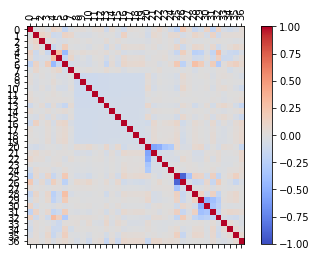

In [26]:
import matplotlib.pyplot as plt
corr = pc
data = pc
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

"MATERIAL EXTRA PROPIO"<br>
Utilización de la librería SeaBorn para mostrar la matríz de correlación. <br>
Con esta librería es posible además incluir los valores dentro de las celdas, y así poder apreciar que entre las características 25 y 26, existe una correlación inversa del 89%.

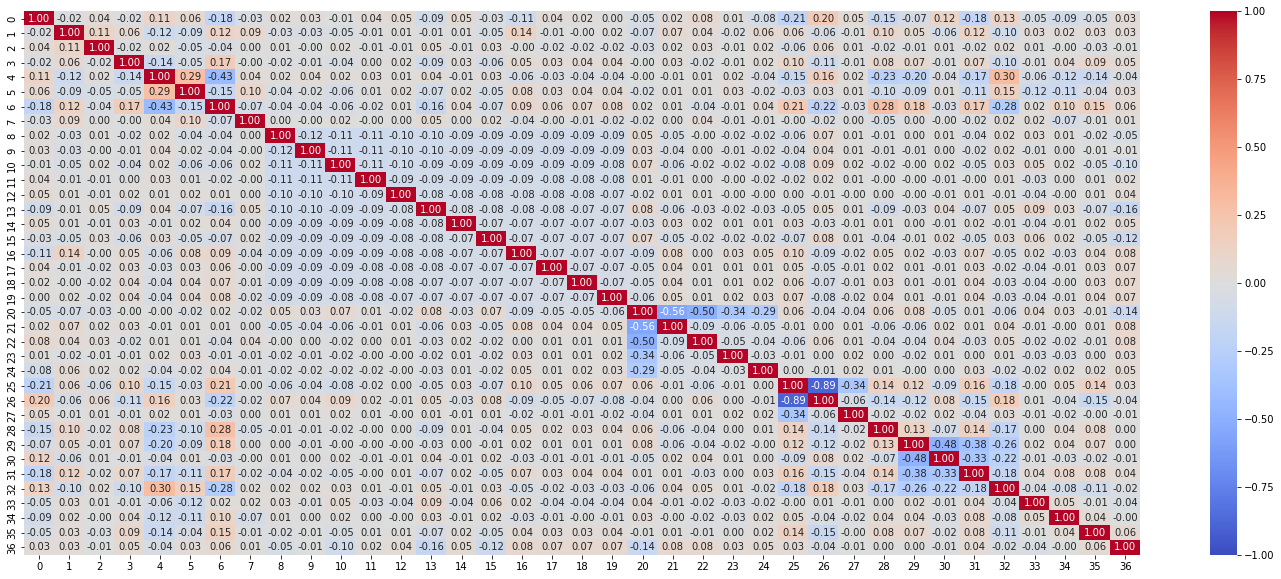

In [27]:
import seaborn as sns
import matplotlib.pylab as plt

plt.figure(figsize=(25,10))
ax = sns.heatmap(pc,
                 annot=True,
                 cmap='coolwarm', 
                 fmt='.2f', 
                 vmin=-1,
                 vmax=1
                 )
plt.show()

## Identificación de outliers y reducción de la dimensionalidad

### Identificación de outliers

Vamos a aplicarlo sobre las características numéricas del dataset inicial.

In [28]:
df_out = df.select('BMI','PhysicalHealth','MentalHealth','SleepTime')

Determinaremos los outliers mediante el método basado en bandas, estas bandas serán el rango intercuartiles:
\begin{eqnarray}
x_L= Q_1- k(Q_3-Q_1) \\
x_U=Q_3+ k(Q_3-Q_1) 
\end{eqnarray}
Calculamos los cuartiles $Q_1$ y $Q_3$.

In [29]:
cuartiles = {
    c: dict(
        zip(["q1", "q3"], df_out.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in df_out.columns
}
display(cuartiles)

{'BMI': {'q1': 24.03, 'q3': 31.42},
 'MentalHealth': {'q1': 0.0, 'q3': 3.0},
 'PhysicalHealth': {'q1': 0.0, 'q3': 2.0},
 'SleepTime': {'q1': 6.0, 'q3': 8.0}}

A partir de los cuartiles obtenemos $x_L$ y $x_U$, aplicando un $k=1.5$ al rango.

In [30]:
for c in cuartiles:
    IQR = cuartiles[c]['q3'] - cuartiles[c]['q1']
    cuartiles[c]['xL'] = cuartiles[c]['q1'] - (IQR * 1.5)
    cuartiles[c]['xU'] = cuartiles[c]['q3'] + (IQR * 1.5)
display(cuartiles)

{'BMI': {'q1': 24.03, 'q3': 31.42, 'xL': 12.945, 'xU': 42.505},
 'MentalHealth': {'q1': 0.0, 'q3': 3.0, 'xL': -4.5, 'xU': 7.5},
 'PhysicalHealth': {'q1': 0.0, 'q3': 2.0, 'xL': -3.0, 'xU': 5.0},
 'SleepTime': {'q1': 6.0, 'q3': 8.0, 'xL': 3.0, 'xU': 11.0}}

Aplicamos estos valores a nuestros datos para determinar si existen outliers.<br><br>
Vemos que así es, que existen outliers en los datos, pero no haremos ningún tratamiento sobre ellos, ya que se determinan como datos importantes para el aprendizaje.

In [31]:
import pyspark.sql.functions as f

df_out.select(
    "*",
    *[
        f.when(
            f.col(c).between(cuartiles[c]['xL'], cuartiles[c]['xU']), 0
        ).otherwise(1).alias(c+"_outlier?") 
        for c in df_out.columns
    ]
).show()

+-----+--------------+------------+---------+------------+-----------------------+---------------------+------------------+
|  BMI|PhysicalHealth|MentalHealth|SleepTime|BMI_outlier?|PhysicalHealth_outlier?|MentalHealth_outlier?|SleepTime_outlier?|
+-----+--------------+------------+---------+------------+-----------------------+---------------------+------------------+
| 16.6|           3.0|        30.0|      5.0|           0|                      0|                    1|                 0|
|20.34|           0.0|         0.0|      7.0|           0|                      0|                    0|                 0|
|26.58|          20.0|        30.0|      8.0|           0|                      1|                    1|                 0|
|24.21|           0.0|         0.0|      6.0|           0|                      0|                    0|                 0|
|23.71|          28.0|         0.0|      8.0|           0|                      1|                    0|                 0|
|28.87| 

### Reducción de la dimensionalidad

Utilizando nuestro dataset *assembled_df* que ya tiene una columna *features* con todas las características, vamos a aplicar una reducción de dimensiones.

Importamos la función PCA del paquete MLlib de Spark y la aplicamos para reducir la dimensionalidad de los datos a dos dimensiones, $k=2$, en lugar de las 37 dimensiones que tiene la columna *features*.<br>
Los nuevos datos se guardan en el propio DataFrame en una columna llamada *pca_features*, de la que mostramos sus primeros registros.

In [32]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
assembled_df = pca_model.transform(assembled_df)

assembled_df.select("pca_features").show(10, truncate=False)

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-25.274211960728113,15.156178751104083]|
|[-2.8074105072993647,-5.265388686587228]|
|[-38.65208382062027,1.4743497390010278] |
|[-3.4128853209410788,-6.267644440349236]|
|[-22.98389960733043,-24.3752003981519]  |
|[-8.23683584033191,-11.448604853904943] |
|[-13.623355845232032,-15.34801737829043]|
|[-8.001543368829166,-11.493187794598732]|
|[-3.7792064279794846,-6.851759111367642]|
|[-5.761096447755955,-10.558861066334117]|
+----------------------------------------+
only showing top 10 rows



Veamos la varianza de los datos reducidos.<br>
Si sumásemos las varianzas de todos las dimensiones nos daría el 100% de la explicación de los datos. En nuestro caso, nos hemos quedado con las 2 mejores dimensiones según la función PCA, siendo de algo más del 70% la explicación de los datos que nos ofrece esta nueva columna.

In [33]:
pca_model.explainedVariance

DenseVector([0.4787, 0.2641])

Visualicemos gráficamente los datos.<br>
Para ello, primero indicar que vamos a utilizar una porción reducida de los datos puesto que para todo el DataFrame tiene un tiempo elevado.<br>
Reutilizaremos el DataFrame *stratified_sample* que generamos en uno de los pasos anteriores (muestreo estratificado), pero que tenemos que regenerar de nuevo para que incluya la columna *pca_features* recien creada.<br>
Así en lugar de 319.795 registros tendremos 53.117 registros, un 16% del total.<br>
El gráfico que se obtiene es similar, pero con una menor densidad de puntos.

In [34]:
stratified_sample = assembled_df.sampleBy(col="Race", 
                                          fractions={"American Indian/Alaskan Native": 0.7,
                                                     "Other": 0.5,
                                                     "White": 0.08,
                                                     "Black": 0.4,
                                                     "Hispanic": 0.4,
                                                     "Asian": 0.5}, 
                                          seed=1234)

"MATERIAL EXTRA PROPIO"<br>
Además de utilizar solo una muestra de datos, se modifica la llamada a *matplotlib* poniendola fuera del bucle, ya que al ser un volumen de datos alto, es mejor generar los puntos que tiene que dibujar en unas listas y esas listas serán las que usaran para alimentar la gráfica. De este modo la llamada a la función gráfica, *plt.scatter*, solo se realiza 1 vez, reduciendo significativamente el tiempo de ejecución.

In [35]:
collected_data = stratified_sample.select("pca_features").collect()

xpoint = np.array([])
ypoint = np.array([])
for i in range(stratified_sample.count()):
    xpoint = np.append(xpoint, collected_data[i][0][0]) 
    ypoint = np.append(ypoint, collected_data[i][0][1])

Dibujamos la gráfica con los datos preparados previamente.

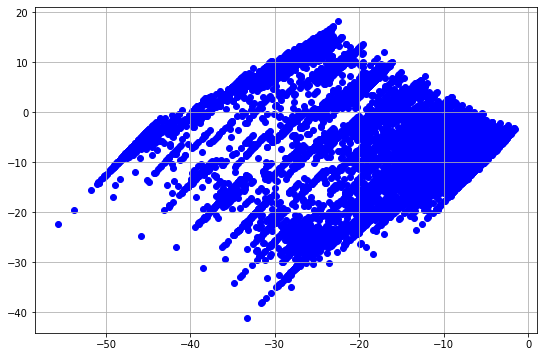

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.scatter(xpoint, ypoint, color="b")  
plt.grid()
plt.show()

---

## Clustering: Algoritmo de las K-medias

Los algoritmos de *clustering* son el principal ejemplo de problemas de aprendizaje no supervisado. Y consisten en buscar patrones dentro de los datos.

### K-Means

Primero estandarizamos los datos para que el algoritmo *K-Means* trabaje mejor.<br>
El resultado se guarda en un nuevo DataFrame, *df_km*, con una nueva columna llamada *standardized*.

In [37]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='pca_features',outputCol='standardized')
fit_scaler = scaler.fit(assembled_df)
df_km = fit_scaler.transform(assembled_df)

df_km.select("standardized").show(5, truncate=False)

+------------------------------------------+
|standardized                              |
+------------------------------------------+
|[-2.782976131546997,2.246890776846278]    |
|[-0.3091275979408736,-0.7805894527036865] |
|[-4.256030885334128,0.2185711111493592]   |
|[-0.37579721190296256,-0.9291730268453495]|
|[-2.5307868793876445,-3.61360299702176]   |
+------------------------------------------+
only showing top 5 rows



Aplicamos el algoritmo K-means, el cual guardamos en un DataFrame llamado *predictions*.

In [38]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='standardized', k=2, initSteps=5, seed=10)
kmeans_model = kmeans.fit(df_km)

predictions = kmeans_model.transform(df_km)

predictions.show(5)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+----------------+-----------+-------------+-------------------+-------------------+----------+-------------+---------------+---------------+-------+-------------+---------------+---------------+--------+-------------+------------+-------------+--------------------+--------------------+-------------+-------------+----------+-------------+-----------------+-----------------+--------------+--------------+--------------------+--------------------+--------------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|HeartDisease_idx|Smoking_idx|  Smoking_vec|AlcoholDrinking_idx|AlcoholDrinking_vec|Stroke_idx|   Stroke_vec|DiffWalking_idx|DiffWalk

Guardamos los resultados de la nueva columna *prediction* en un variable en memoria.

In [39]:
import numpy as np
pred = np.array(predictions.select("prediction").collect()).reshape(-1)
display(pred)

array([0, 0, 1, ..., 0, 0, 0])

Obtenemos los centroides.

In [40]:
centroides = kmeans_model.clusterCenters()

centroides = [cluster * fit_scaler.std for cluster in centroides]

print("Centroides: ")
for c in centroides:
    print(c)

Centroides: 
[-6.75513696 -5.55506803]
[-29.03204748 -17.00580533]


Evaluamos los resultados obtenidos con el coeficiente Silhouette (o valor de la silueta en español). Va de -1 a +1, donde un valor alto indica que el objeto está bien emparejado.<br>
Para nuestro caso tenemos un valor de 0.76 por lo que es un valor bueno.

In [41]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("El coeficiente Silhouette para este modelo es " + str(silhouette))

El coeficiente Silhouette para este modelo es 0.7682151038340782


Gráficamente se vería así.

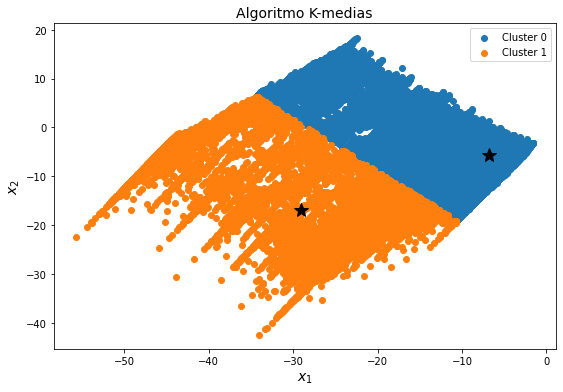

In [42]:
collected_data = df_km.select("pca_features").collect()
collected_data = np.array(collected_data).reshape(-1,2)

plt.figure(figsize=(9, 6))
for k in np.unique(pred):
  plt.scatter(collected_data[pred==k, 0], collected_data[pred==k, 1], label="Cluster {}".format(k)) 
  plt.plot(centroides[k][0], centroides[k][1], 'k*', markersize=14) 

plt.title("Algoritmo K-medias", fontsize=14)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.legend()
plt.show()

---

## Algoritmos de clasificación

Los algoritmos de clasificación son uno de los dos tipos en los que pueden divisirse los algoritmos de aprendizaje supervisado. Estos algoritmos suponen que partimos de un conjunto de datos etiquetado previamente.

### Pre-procesamiento del dataset y obtención de conjuntos de entrenamiento y test

Los datos ya se encuentran preprocesados en el DataFrame *df_km*, que tiene hasta datos estandarizados.

Antes de dividir el dataset en un conjunto de entrenamiento y otro de test, vamos a reducir el tamaño de la muestra y a estratificar nuestra columna etiqueta, *HeartDisease*, puesto que está muy descompensada.<br>
Primero reducimos la muestra por *Race* y después por *HeartDisease*.

In [43]:
df_clf = df_km.sampleBy(col="Race", 
                        fractions={"American Indian/Alaskan Native": 0.8,
                                   "Other": 0.6,
                                   "White": 0.1,
                                   "Black": 0.5,
                                   "Hispanic": 0.5,
                                   "Asian": 0.6}, 
                        seed=1234)
df_clf.groupBy("HeartDisease").count().show(truncate=False)
df_clf = df_clf.sampleBy(col="HeartDisease", fractions={"No": 0.15,
                                                      "Yes": 0.8}, 
                                          seed=1234)
df_clf.groupBy("HeartDisease").count().show(truncate=False)

+------------+-----+
|HeartDisease|count|
+------------+-----+
|No          |60496|
|Yes         |4996 |
+------------+-----+

+------------+-----+
|HeartDisease|count|
+------------+-----+
|No          |9159 |
|Yes         |4046 |
+------------+-----+



Dividimos los datos entre entrenamiento (70%) y test (30%).

In [44]:
(train_df, test_df) = df_clf.randomSplit([0.7, 0.3], seed=100)

print("Número de filas entrenamiento: {train:d}".format(train=train_df.count()))
print("Número de filas test: {test:d}".format(test=test_df.count()))

Número de filas entrenamiento: 9271
Número de filas test: 3934


### Metodología aplicada a los distintos algoritmos de clasificación
En todos los casos se realizan varios pasos, que serán:
* Ajuste de hiperparámetros, donde con validación cruzada se harán varias pasadas a los datos para determinar los mejores hiperparámetros. Se usará una $k=3$.
* Entrenamiento, con los hiperparámetros definidos en el punto anterior, se entrena el modelo.
* Evaluación, se utiliza el método *accuracy* donde se obtiene la probabilidad del porcentaje de acierto.
* Matriz de confusión, mostramos la matriz de confusión de los datos reales frente a los predichos por el algoritmo.
* Conclusión Final, breve consideración de los resultados obtenidos en todos los algoritmos de clasificación. Es el último campo tras las redes neuronales.

Las características serán obtenidas de la columna *standardized* y la etiqueta de la columna *HeartDisease_idx*, la cual es númerica, ya que se generó en los primeros pasos con la función *StringIndexer*.

### Regresión logística

**Ajuste de hiperparámetros**

In [45]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(labelCol="HeartDisease_idx", featuresCol="standardized", 
                        maxIter=100)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1, 0.1, 0.01, 0.001, 0.0001, 0.000001, 0.0000001]) \
    .build()
  
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease_idx", 
                                          rawPredictionCol="prediction")

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df)

print("RegParam: " + str(cvModel.bestModel.getRegParam()))

RegParam: 0.001


**Entrenamiento**



In [46]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="HeartDisease_idx", featuresCol="standardized", 
                        maxIter=100, regParam=cvModel.bestModel.getRegParam())

lr_model = lr.fit(train_df)
pred = lr_model.transform(test_df)

pred.select("HeartDisease_idx", "features", "prediction").show(10)

+----------------+--------------------+----------+
|HeartDisease_idx|            features|prediction|
+----------------+--------------------+----------+
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,2,3,6,7,8,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,4,5,...|       0.0|
|             0.0|(37,[0,1,2,3,6,10...|       0.0|
|             0.0|(37,[0,2,3,10,21,...|       0.0|
|             0.0|(37,[0,1,2,3,4,7,...|       1.0|
|             0.0|(37,[0,1,2,3,5,6,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
+----------------+--------------------+----------+
only showing top 10 rows



**Evaluación**

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="HeartDisease_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7196237925775293


**Matriz de confusión**

In [48]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = pred.select(['prediction','HeartDisease_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[[2558.  181.]
 [ 922.  273.]]


### Máquinas de Vectores de Soporte (SVM) - Lineales

**Ajuste de hiperparámetros**


In [49]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lsvc = LinearSVC(labelCol="HeartDisease_idx", featuresCol="standardized", 
                 maxIter=100)

paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam,[1, 0.1, 0.01, 0.001, 0.0001, 0.000001, 0.0000001]) \
    .build()
  
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease_idx", 
                                          rawPredictionCol="prediction")

crossval = CrossValidator(estimator=lsvc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df)

print("RegParam: " + str(cvModel.bestModel.getRegParam()))

RegParam: 1e-07


**Entrenamiento**

In [50]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="HeartDisease_idx", featuresCol="standardized", 
                 maxIter=100, regParam=cvModel.bestModel.getRegParam())

lsvc_model = lsvc.fit(train_df)
pred = lsvc_model.transform(test_df)

pred.select("HeartDisease_idx", "features", "prediction").show(10)

+----------------+--------------------+----------+
|HeartDisease_idx|            features|prediction|
+----------------+--------------------+----------+
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,2,3,6,7,8,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,4,5,...|       0.0|
|             0.0|(37,[0,1,2,3,6,10...|       0.0|
|             0.0|(37,[0,2,3,10,21,...|       0.0|
|             0.0|(37,[0,1,2,3,4,7,...|       1.0|
|             0.0|(37,[0,1,2,3,5,6,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
+----------------+--------------------+----------+
only showing top 10 rows



**Evaluación**

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease_idx", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7201321809862735


**Matriz de confusión**

In [52]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = pred.select(['prediction','HeartDisease_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[[2535.  204.]
 [ 897.  298.]]


### Árboles de decisión - Clasificador Random Forest

**Ajuste de hiperparámetros**

In [53]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(labelCol="HeartDisease_idx", 
                            featuresCol="standardized")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [10, 15, 20]) \
    .addGrid(rf.numTrees, [25, 50, 100]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease_idx", 
                                          rawPredictionCol="prediction")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))
print("NumTrees: " + str(cvModel.bestModel.getNumTrees))

MaxDepth: 15
NumTrees: 50


**Entrenamiento**

In [54]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="HeartDisease_idx", 
                            featuresCol="standardized", 
                            maxDepth=cvModel.bestModel.getMaxDepth(), 
                            numTrees=cvModel.bestModel.getNumTrees, 
                            seed=10)

rf_model = rf.fit(train_df)
pred = rf_model.transform(test_df)

pred.select("HeartDisease_idx", "features", "prediction").show(10)

+----------------+--------------------+----------+
|HeartDisease_idx|            features|prediction|
+----------------+--------------------+----------+
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,2,3,6,7,8,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,4,5,...|       0.0|
|             0.0|(37,[0,1,2,3,6,10...|       0.0|
|             0.0|(37,[0,2,3,10,21,...|       0.0|
|             0.0|(37,[0,1,2,3,4,7,...|       1.0|
|             0.0|(37,[0,1,2,3,5,6,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
+----------------+--------------------+----------+
only showing top 10 rows



**Evaluación**

In [55]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease_idx", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7130147432638536


**Matriz de confusión**

In [56]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = pred.select(['prediction','HeartDisease_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[[2494.  245.]
 [ 884.  311.]]


### Árboles de Decisión - Gradient-boosted tree classifier

**Ajuste de hiperparámetros**

In [57]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol="HeartDisease_idx", featuresCol="standardized")

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 6, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease_idx", 
                                          rawPredictionCol="prediction")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))

MaxDepth: 3


**Entrenamiento**

In [58]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="HeartDisease_idx", featuresCol="standardized", 
                    maxDepth=cvModel.bestModel.getMaxDepth(), seed=10)

gbt_model = gbt.fit(train_df)
pred = gbt_model.transform(test_df)

pred.select("HeartDisease_idx", "features", "prediction").show(10)

+----------------+--------------------+----------+
|HeartDisease_idx|            features|prediction|
+----------------+--------------------+----------+
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,2,3,6,7,8,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,4,5,...|       0.0|
|             0.0|(37,[0,1,2,3,6,10...|       0.0|
|             0.0|(37,[0,2,3,10,21,...|       0.0|
|             0.0|(37,[0,1,2,3,4,7,...|       1.0|
|             0.0|(37,[0,1,2,3,5,6,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
+----------------+--------------------+----------+
only showing top 10 rows



**Evaluación**

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease_idx", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7183528215556685


**Matriz de confusión**

In [60]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = pred.select(['prediction','HeartDisease_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[[2529.  210.]
 [ 898.  297.]]


### Redes neuronales

**Entrenamiento**

In [61]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [2, 3, 3, 2]

mlp = MultilayerPerceptronClassifier(labelCol="HeartDisease_idx", 
                                     featuresCol="standardized", 
                                     maxIter=1500, 
                                     layers=layers, 
                                     seed=10)

mlp_model = mlp.fit(train_df)
pred = mlp_model.transform(test_df)

pred.select("HeartDisease_idx", "features", "prediction").show(10)

+----------------+--------------------+----------+
|HeartDisease_idx|            features|prediction|
+----------------+--------------------+----------+
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,2,3,6,7,8,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,4,5,...|       0.0|
|             0.0|(37,[0,1,2,3,6,10...|       0.0|
|             0.0|(37,[0,2,3,10,21,...|       0.0|
|             0.0|(37,[0,1,2,3,4,7,...|       1.0|
|             0.0|(37,[0,1,2,3,5,6,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
|             0.0|(37,[0,1,2,3,6,7,...|       0.0|
+----------------+--------------------+----------+
only showing top 10 rows



**Evaluación**

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease_idx", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7188612099644128


**Matriz de confusión**

In [63]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = pred.select(['prediction','HeartDisease_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[[2503.  236.]
 [ 870.  325.]]


### Conclusión final para clasificación<br>
Estos son los valores que ha dado de *accuracy* para cada algoritmo:
* Regresión logística: 0.7196
* Máquinas de Vectores de Soporte (SVM) - Lineales: 0.7201
* Árboles de decisión - Clasificador Random Forest: 0.7130
* Árboles de Decisión - Gradient-boosted tree classifier: 0.7183
* Redes neuronales: 0.7188

Los valores son prácticamente similares, ya que entre el de mayor valor, SVM, y el de menor valor, Random Forest, solo hay una diferencia de 0.0071 milésimas. Por lo que no podemos decir que haya uno mejor que otro para los datos entrenados.<br>
Podría decirse que la probabilidad de acierto es buena, pero considerando que el objetivo es determinar si se sufre una dolencia cardiaca, debería ser mayor.<br>
Para intentar conseguir un mejor acierto, se debería comenzar de nuevo con la selección de datos, ya sea haciendo una reducción de datos menos agresiva por ejemplo.

Veamos que ocurriría para el algoritmo de redes neuronales si le insertamos todas las características, columna *features* en lugar de la reducida utilizada.

#### Redes neuronales II

**Entrenamiento y Evaluación**

In [90]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [37, 60, 2]

mlp = MultilayerPerceptronClassifier(labelCol="HeartDisease_idx", 
                                     featuresCol="features", 
                                     maxIter=1500, 
                                     layers=layers, 
                                     seed=10)

mlp_model = mlp.fit(train_df)
pred = mlp_model.transform(test_df)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease_idx", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.769954245043213


¡Hemos conseguido llegar al 0.7699!<br>
Por tanto la capacidad de mejora es posible.

---

## Algoritmos de regresión

Los algoritmos de regresión son el segundo de los dos tipos en los que pueden divisirse los algoritmos de aprendizaje supervisado. Estos algoritmos suponen que partimos de un conjunto de datos etiquetado previamente. 

Nota: Se ha buscado otro dataset, ya que el usado en los pasos anteriores no daba buen rendimiento para los estimadores de regresión. 

### Dataset que se utilizará

Este conjunto de datos contiene las respuestas de un sensor meteorológico que recopiló diferentes variables climáticas, como temperaturas y precipitaciones.

### Contenido
El conjunto de datos contiene 6574 instancias de respuestas promedio diarias de una matriz de 5 sensores de variables meteorológicas integrados en una estación meteorológica. El dispositivo estaba ubicado en el campo en un área significativamente vacía, a 21M. Los datos se registraron desde enero de 1961 hasta diciembre de 1978 (17 años).

Fuente: fedesoriano. (April 2022). Wind Speed Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset

Explicación de los campos del dataset:<br>
**DATE**: Fecha (YYYY-MM-DD)<br>
**WIND**: Velocidad media del viento (nudos)<br>
**IND**: Valor primer indicador<br>
**RAIN**: Cantidad de precipitación (mm)<br>
**IND.1**: Valor segundo indicador<br>
**T.MAX**: Temperatura máxima (°C)<br>
**IND.2**: Third indicator value<br>
**T.MIN**: Temperatura mínima (°C)<br>
**T.MIN.G**: (grass minimum temperature) Temperatura mínima registrada al aire libre sobre césped corto, con el bulbo del termómetro justo en contacto con las puntas de las briznas de hierba. También se describe como la temperatura a 5 cm (2 pulgadas) sobre el suelo. (°C)<br>

Este último campo será nuestra variable independiente a calcular.

Descargamos el dataset, ejecutando el siguiente comando o manualmente, 
[aquí](https://drive.google.com/file/d/1TKDpG5BeISdo58caUzm-OuA59apRTUXO/view?usp=sharing).

In [64]:
!gdown https://drive.google.com/uc?id=1TKDpG5BeISdo58caUzm-OuA59apRTUXO

Downloading...
From: https://drive.google.com/uc?id=1TKDpG5BeISdo58caUzm-OuA59apRTUXO
To: /content/wind_dataset.csv
100% 292k/292k [00:00<00:00, 65.2MB/s]


Verificamos que se ha descargado mostrando las primeras líneas del fichero.

In [65]:
!head wind_dataset.csv

"DATE","WIND","IND","RAIN","IND.1","T.MAX","IND.2","T.MIN","T.MIN.G"
1961-01-01,13.67,"0",0.2,"0",9.5,"0",3.7,-1
1961-01-02,11.5,"0",5.1,"0",7.2,"0",4.2,1.1
1961-01-03,11.25,"0",0.4,"0",5.5,"0",0.5,-0.5
1961-01-04,8.63,"0",0.2,"0",5.6,"0",0.4,-3.2
1961-01-05,11.92,"0",10.4,"0",7.2,"1",-1.5,-7.5
1961-01-06,10.67,"0",0,"0",6.5,"0",1.2,-2
1961-01-07,9.17,"0",1.9,"0",9.2,"1",-2.4,-7.1
1961-01-08,14.29,"0",0,"0",6.6,"0",3.1,0
1961-01-09,8.04,"0",8.3,"0",6.8,"0",2.4,-0.8


Creamos un nuevo cluster de Spark.

In [92]:
from pyspark.sql import SparkSession

spark_reg = SparkSession.builder.master("local").appName("Practica 2 - SBD - Regresion").getOrCreate()
spark_reg

Creamos un DataFrame de Spark a partir del archivo CSV descargado anteriormente y que contiene el dataset que utilizaremos.

In [67]:
df_reg = spark_reg.read.csv('wind_dataset.csv', 
                            header=True, 
                            sep=",", 
                            inferSchema = "true"
                            )

df_reg.show()

+----------+-----+---+----+-----+-----+-----+-----+-------+
|      DATE| WIND|IND|RAIN|IND.1|T.MAX|IND.2|T.MIN|T.MIN.G|
+----------+-----+---+----+-----+-----+-----+-----+-------+
|1961-01-01|13.67|  0| 0.2|    0|  9.5|    0|  3.7|     -1|
|1961-01-02| 11.5|  0| 5.1|    0|  7.2|    0|  4.2|    1.1|
|1961-01-03|11.25|  0| 0.4|    0|  5.5|    0|  0.5|   -0.5|
|1961-01-04| 8.63|  0| 0.2|    0|  5.6|    0|  0.4|   -3.2|
|1961-01-05|11.92|  0|10.4|    0|  7.2|    1| -1.5|   -7.5|
|1961-01-06|10.67|  0| 0.0|    0|  6.5|    0|  1.2|     -2|
|1961-01-07| 9.17|  0| 1.9|    0|  9.2|    1| -2.4|   -7.1|
|1961-01-08|14.29|  0| 0.0|    0|  6.6|    0|  3.1|      0|
|1961-01-09| 8.04|  0| 8.3|    0|  6.8|    0|  2.4|   -0.8|
|1961-01-10|11.42|  0| 0.0|    0|  6.5|    0|    3|    0.5|
|1961-01-11| 7.54|  0| 0.5|    0|   10|    1| -3.1|   -7.7|
|1961-01-12|15.54|  0| 6.0|    0| 12.2|    1| -3.3|     NA|
|1961-01-13| 4.63|  0| 0.0|    0| 13.1|    0|  5.5|    3.3|
|1961-01-14| 3.08|  0| 0.0|    0|  5.6| 

### Pre-procesamiento del dataset y obtención de conjuntos de entrenamiento y test

Vemos los tipos de datos del DataFrame.

In [68]:
df_reg.printSchema()

root
 |-- DATE: string (nullable = true)
 |-- WIND: double (nullable = true)
 |-- IND: integer (nullable = true)
 |-- RAIN: double (nullable = true)
 |-- IND.1: string (nullable = true)
 |-- T.MAX: string (nullable = true)
 |-- IND.2: string (nullable = true)
 |-- T.MIN: string (nullable = true)
 |-- T.MIN.G: string (nullable = true)



Hacemos un conteo del número de registros.

In [69]:
df_reg.count()

6574

Eliminamos las columnas de los indicadores, ya que no nos dan mucha información.

In [70]:
df_reg = df_reg.drop("IND","IND.1","IND.2")

Renombramos los nombres de las columnas de las temperaturas quitando los puntos en el nombre, ya que para determinadas funciones pueden dar problemas.

In [71]:
df_reg = df_reg.withColumnRenamed('T.MAX', 'TMAX') \
               .withColumnRenamed('T.MIN', 'TMIN') \
               .withColumnRenamed('T.MIN.G', 'TMING')


Cambiamos el tipo de dato de *String* a *Double* para los campos de temperatura, ya que deben ser numéricos para poder procesarse.<br>
Además se creará una nueva columna *MES* que tendrá el mes correspondiente de registro, ya que se considera que será relevante, mientras que el día y el año no tienen esta consideración.

In [72]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType

df_reg = df_reg.withColumn('TMAX', col('TMAX').cast(DoubleType())) \
               .withColumn('TMIN', col('TMIN').cast(DoubleType())) \
               .withColumn('TMING', col('TMING').cast(DoubleType())) \
               .withColumn('MES', df_reg.DATE.substr(6,2).cast(DoubleType()))

Verificamos si tenemos valores nulos en el DataFrame.

In [73]:
df_reg.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_reg.columns]).show()

+----+----+----+----+----+-----+---+
|DATE|WIND|RAIN|TMAX|TMIN|TMING|MES|
+----+----+----+----+----+-----+---+
|   0|   0|   0| 621| 674|  360|  0|
+----+----+----+----+----+-----+---+



Puesto que existen valores nulos, procedemos a eliminar los registros que contengan algún valor nulo en las columnas de temperatura.

In [74]:
df_reg = df_reg.na.drop(subset = ['TMAX', 'TMIN', 'TMING'])

Volvemos a comprobar de nuevo si tenemos valores nulos.

In [75]:
df_reg.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_reg.columns]).show()

+----+----+----+----+----+-----+---+
|DATE|WIND|RAIN|TMAX|TMIN|TMING|MES|
+----+----+----+----+----+-----+---+
|   0|   0|   0|   0|   0|    0|  0|
+----+----+----+----+----+-----+---+



Realizamos un conteo de los registros que tenemos disponibles en el DataFrame.<br>
Y comprobamos que solo hemos eliminado un 15% del total original.

In [76]:
df_reg.count()

5638

Utilizaremos el *VectorAssembler* para generar una nueva columna que contendrá  todas las características del DataFrame.<br>
Esta columna se llamará *features_reg*.

In [77]:
from pyspark.ml.feature import VectorAssembler

assembler_reg = VectorAssembler(
  inputCols = ['WIND', 'RAIN', 'TMAX', 'TMIN', 'MES'], 
  outputCol = "features_reg"
  )
assembled_df_reg = assembler_reg.transform(df_reg)

assembled_df_reg.select("features_reg").show(5, truncate=False)

+-------------------------+
|features_reg             |
+-------------------------+
|[13.67,0.2,9.5,3.7,1.0]  |
|[11.5,5.1,7.2,4.2,1.0]   |
|[11.25,0.4,5.5,0.5,1.0]  |
|[8.63,0.2,5.6,0.4,1.0]   |
|[11.92,10.4,7.2,-1.5,1.0]|
+-------------------------+
only showing top 5 rows



Para nuestro caso particular, al ser pocas las variables, no se estima necesaria la reducción de la dimensionalidad.<br>
En caso de querer proceder a su reducción, este sería el código a ejecutar:
```
from pyspark.ml.feature import PCA
# Reducimos la dimensionalidad de los datos (a dos dimensiones)
pca_reg = PCA(k=2, inputCol="features_reg", outputCol="pca_features_reg")
pca_model_reg = pca_reg.fit(assembled_df_reg)
assembled_df_reg = pca_model_reg.transform(assembled_df_reg)
# Mostramos la nueva columna de DenseVectors 
assembled_df_reg.select("pca_features_reg").show(10, truncate=False)
# Podemos visualizar la cantidad de varianza explicada por cada componente principal
pca_model_reg.explainedVariance
```

Ahora vamos a dividir el dataset en un conjunto de entrenamiento y otro de test. Gracias a esto, podremos estimar cada modelo sobre el conjunto de entrenamiento, utilizando el conjunto de test para validar los resultados obtenidos.<br>
Como es una serie temporal, en lugar de generar los datos aleatorios, creamos los datos de entrenamiento con los primeros registros, dejando de test el resto.<br>
Se realiza un reparto de un 70% aproximadamente para entrenamiento, desde 1961 hasta mediados de 1974, y desde ese punto hasta 1978 para test.

In [78]:
train_df_reg = assembled_df_reg.limit(4000)
test_df_reg = assembled_df_reg.subtract(train_df_reg).sort("DATE")

print(f"Número de filas df entrenamiento: {train_df_reg.count():d}")
print(f"Número de filas df test: {test_df_reg.count():d}")
train_df_reg.show(5)
test_df_reg.show(5)

Número de filas df entrenamiento: 4000
Número de filas df test: 1638
+----------+-----+----+----+----+-----+---+--------------------+
|      DATE| WIND|RAIN|TMAX|TMIN|TMING|MES|        features_reg|
+----------+-----+----+----+----+-----+---+--------------------+
|1961-01-01|13.67| 0.2| 9.5| 3.7| -1.0|1.0|[13.67,0.2,9.5,3....|
|1961-01-02| 11.5| 5.1| 7.2| 4.2|  1.1|1.0|[11.5,5.1,7.2,4.2...|
|1961-01-03|11.25| 0.4| 5.5| 0.5| -0.5|1.0|[11.25,0.4,5.5,0....|
|1961-01-04| 8.63| 0.2| 5.6| 0.4| -3.2|1.0|[8.63,0.2,5.6,0.4...|
|1961-01-05|11.92|10.4| 7.2|-1.5| -7.5|1.0|[11.92,10.4,7.2,-...|
+----------+-----+----+----+----+-----+---+--------------------+
only showing top 5 rows

+----------+-----+----+----+----+-----+---+--------------------+
|      DATE| WIND|RAIN|TMAX|TMIN|TMING|MES|        features_reg|
+----------+-----+----+----+----+-----+---+--------------------+
|1974-06-06| 17.5| 1.3|13.5| 6.0|  2.5|6.0|[17.5,1.3,13.5,6....|
|1974-06-07|10.21| 0.1|15.0| 6.0|  2.2|6.0|[10.21,0.1,15.0,6.

### Metodología aplicada a los distintos algoritmos de regresión
En todos los casos se realizan varios pasos, que serán:
* Ajuste de hiperparámetros, donde con validación cruzada se harán varias pasadas a los datos para determinar los mejores hiperparámetros. Se usuará una $k=3$.
* Entrenamiento, con los hiperparámetros definidos en el punto anterior, se entrena el modelo.
* Evaluación, calculamos 3 métricas:
 * Error cuadrático medio (RMSE): RMSE es una regla de puntuación cuadrática que también mide la magnitud media del error.
 * Error absoluto medio (MAE): MAE mide la magnitud promedio de los errores en un conjunto de predicciones, sin considerar su dirección. 
 * Coeficiente de determinación ($R^2$): El valor $R^2$ mide el porcentaje de variación de la variable de respuesta con respecto una o más variables predictoras. Por lo general, un mayor valor de $R^2$ implica un mejor ajuste del modelo a sus datos. El $R^2$ siempre se encuentra entre 0 y 1.
* Visualización, mostramos una gráfica con la comparativa de los valores reales y predichos.
* Conclusión, breve consideración de los resultados obtenidos.

Las características, propiedades o variables independientes serán obtenidas de la columna *features_reg* y la variable independiente de la columna *TMING*.<br>
Creamos dos variables para utilizar en los estimadores (algoritmos de regresión) para facilitar en el futuro posibles cambios o correcciones que se realizar.<br>
Tenemos *propiedades* que contiene el valor de la columna con las variables independientes del DataFrame. Y valor_dependiente que contiene, como su nombre indica, el nombre de la columna del termino a predecir.

In [79]:
propiedades = 'features_reg'
variable_dependiente = 'TMING'

### Árboles de Decisión - Random Forest regression

**Ajuste de hiperparámetros**

In [80]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(labelCol=variable_dependiente, 
                           featuresCol=propiedades)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 6, 10]) \
    .addGrid(rf.numTrees, [100, 150, 200]) \
    .build()

evaluator = RegressionEvaluator(labelCol=variable_dependiente, 
                                predictionCol="prediction",
                                metricName="rmse")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df_reg)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))
print("NumTrees: " + str(cvModel.bestModel.getNumTrees))

MaxDepth: 10
NumTrees: 150


**Entrenamiento**

In [81]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol=variable_dependiente, 
                           featuresCol=propiedades, 
                           maxDepth=cvModel.bestModel.getMaxDepth(), 
                           numTrees=cvModel.bestModel.getNumTrees, 
                           seed=10)

rf_model = rf.fit(train_df_reg)
pred = rf_model.transform(test_df_reg)

pred.select(propiedades, variable_dependiente, "prediction").show(10)

+--------------------+-----+------------------+
|        features_reg|TMING|        prediction|
+--------------------+-----+------------------+
|[17.5,1.3,13.5,6....|  2.5| 3.868502457374594|
|[10.21,0.1,15.0,6...|  2.2| 2.925340757145614|
|[7.21,6.7,14.6,7....|  3.0| 4.006150528672076|
|[10.34,7.2,12.5,7...|  3.0| 4.286635308774036|
|[11.38,0.0,15.5,5...|  0.5|2.0515408971508413|
|[14.12,0.0,21.2,8...|  4.6| 6.518181024263804|
|[3.42,0.0,17.3,13...|  9.5| 9.597487209378166|
|[5.33,0.0,18.4,8....|  2.0|4.3728978766272935|
|[4.25,0.0,19.1,7....|  0.5|  2.80371901255443|
|[3.29,0.0,18.8,9....|  6.0| 5.229671938817301|
+--------------------+-----+------------------+
only showing top 10 rows



**Evaluación**

In [82]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=variable_dependiente, 
                                predictionCol="prediction")

rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
print("Error cuadrático medio (RMSE): {}".format(rmse))
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
print("Error absoluto medio (MAE): {}".format(mae))
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print("Coeficiente de determinación R^2: {}".format(r2))

Error cuadrático medio (RMSE): 2.9138479098803227
Error absoluto medio (MAE): 2.3204037608031873
Coeficiente de determinación R^2: 0.7427219832974832


**Visualizar la predicción**

Por último, podemos probar a visualizar como ha quedado nuestra predicción con respecto a la realidad.

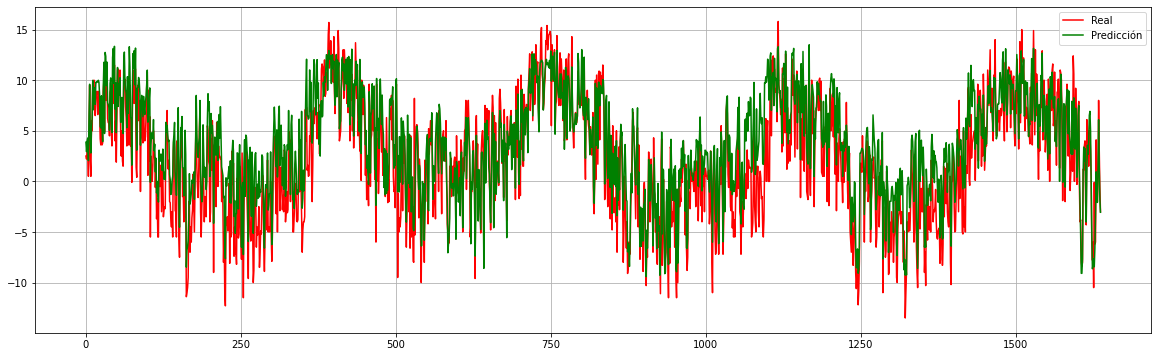

In [83]:
import numpy as np
collected_data = np.array(pred.select(variable_dependiente, 
                                      "prediction").collect())

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(collected_data[:, 0], c="r", label="Real")
plt.plot(collected_data[:, 1], c="g", label="Predicción")
plt.legend()
plt.grid()
plt.show()

**Conclusión**<br>
Si observamos el coeficiente de determinación, tenemos una probabildad de acierto de **0,7433**, lo cual entendemos que no está mal. En la gráfica podemos observar que hay muchas zonas solapadas entre la predicción y lo real, y que posiblemente los fallos se deban a días anómalos donde se ven picos tanto por arriba como por abajo que se alejan de la media prevista.

### Árboles de Decisión - Gradient-boosted tree regression

**Ajuste de hiperparámetros**

In [84]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(labelCol=variable_dependiente, featuresCol=propiedades)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 6, 10]) \
    .build()

evaluator = RegressionEvaluator(labelCol=variable_dependiente, 
                                predictionCol="prediction",
                                metricName="rmse")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df_reg)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))

MaxDepth: 3


**Entrenamiento**

In [85]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol=variable_dependiente, 
                   featuresCol=propiedades,
                   maxDepth=cvModel.bestModel.getMaxDepth(), 
                   seed=10)

gbt_model = gbt.fit(train_df_reg)
pred = gbt_model.transform(test_df_reg)

pred.select(propiedades, variable_dependiente, "prediction").show(10)

+--------------------+-----+------------------+
|        features_reg|TMING|        prediction|
+--------------------+-----+------------------+
|[17.5,1.3,13.5,6....|  2.5| 4.434214320908985|
|[10.21,0.1,15.0,6...|  2.2| 3.936593310800323|
|[7.21,6.7,14.6,7....|  3.0| 4.075078846941272|
|[10.34,7.2,12.5,7...|  3.0| 4.396373637084444|
|[11.38,0.0,15.5,5...|  0.5|1.8390627738559897|
|[14.12,0.0,21.2,8...|  4.6| 6.797183539594711|
|[3.42,0.0,17.3,13...|  9.5|10.785447633290547|
|[5.33,0.0,18.4,8....|  2.0| 4.072910095198408|
|[4.25,0.0,19.1,7....|  0.5| 3.055063746982341|
|[3.29,0.0,18.8,9....|  6.0| 6.073698239963578|
+--------------------+-----+------------------+
only showing top 10 rows



**Evaluación**

In [86]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=variable_dependiente, 
                                predictionCol="prediction")

rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
print("Error cuadrático medio (RMSE): {}".format(rmse))
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
print("Error absoluto medio (MAE): {}".format(mae))
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print("Coeficiente de determinación R^2: {}".format(r2))

Error cuadrático medio (RMSE): 2.964587579484166
Error absoluto medio (MAE): 2.368967456062863
Coeficiente de determinación R^2: 0.7336838589687338


**Visualizar la predicción**

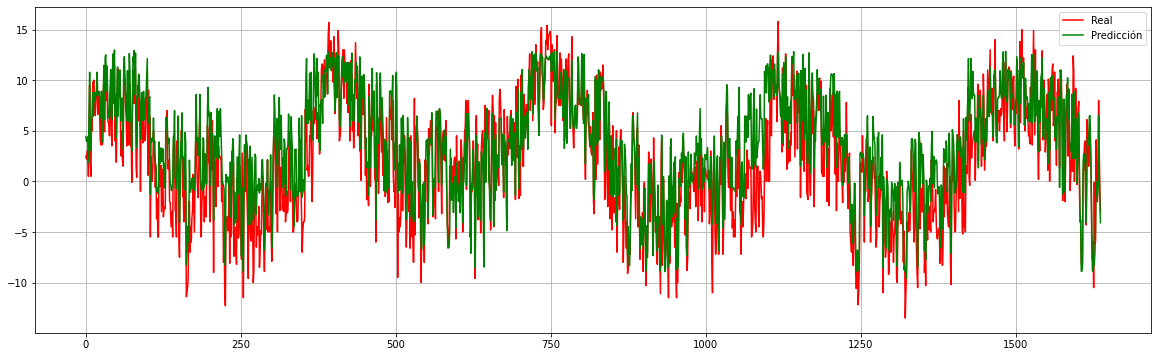

In [87]:
import numpy as np
collected_data = np.array(pred.select(variable_dependiente, 
                                      "prediction").collect())

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(collected_data[:, 0], c="r", label="Real")
plt.plot(collected_data[:, 1], c="g", label="Predicción")
plt.legend()
plt.grid()
plt.show()

**Conclusión**<br>
Podemos llegar las mismas conclusiones que en el estimador anterior, aunque con una precisión menor, ya que el coeficiente de determinación en este caso es de **0,7336** que es una centésima menor.

---